# Problem 1:

Once again consider the plane-strain compression problem shown in "data/plane-strain.png". In this problem you are given node features for 100 parts. These node features have been extracted by processing each part shape using a neural network. You will train a neural network to von Mises stress at each node given its 60 features. Then you will analyze $R^2$ for the training and testing data, both for the full dataset and for individual shapes within each dataset.

#### Summary of deliverables

- Neural network model definition
- Training function
- Training loss curve
- Overall $R^2$ on training and testing data
- Predicted-vs-actual plots for training and testing data
- Histograms of $R^2$ distributions on training and testing shapes
- Median $R^2$ values across training and testing shapes

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
from torch import nn, optim

def plot_shape(dataset, index, model=None, lims=None):
    x = dataset["coordinates"][index][:,0]
    y = dataset["coordinates"][index][:,1]

    if model is None:
        c = dataset["stress"][index]
    else:
        c = model(torch.tensor(dataset["features"][index])).detach().numpy().flatten()

    if lims is None:
        lims = [min(c),max(c)]    

    plt.scatter(x,y,s=5,c=c,cmap="jet",vmin=lims[0],vmax=lims[1])
    plt.colorbar(orientation="horizontal", shrink=.75, pad=0,ticks=lims)
    plt.axis("off")
    plt.axis("equal")

def plot_shape_comparison(dataset, index, model, title=""):
    plt.figure(figsize=[6,3.2], dpi=120)
    plt.subplot(1,2,1)
    plot_shape(dataset,index)
    plt.title("Ground Truth",fontsize=9,y=.96)
    plt.subplot(1,2,2)
    c = dataset["stress"][index]
    plot_shape(dataset, index, model, lims = [min(c), max(c)])
    plt.title("Prediction",fontsize=9,y=.96)
    plt.suptitle(title)
    plt.show()

def load_dataset(path):
    dataset = np.load(path)
    coordinates = []
    features = []
    stress = []
    N = np.max(dataset[:,0].astype(int)) + 1
    split = int(N*.8)
    for i in range(N):
        idx = dataset[:,0].astype(int) == i
        data = dataset[idx,:]
        coordinates.append(data[:,1:3])
        features.append(data[:,3:-1])
        stress.append(data[:,-1])
    dataset_train = dict(coordinates=coordinates[:split], features=features[:split], stress=stress[:split])
    dataset_test = dict(coordinates=coordinates[split:], features=features[split:], stress=stress[split:])
    X_train, X_test = np.concatenate(features[:split], axis=0), np.concatenate(features[split:], axis=0)
    y_train, y_test = np.concatenate(stress[:split], axis=0), np.concatenate(stress[split:], axis=0)
    return dataset_train, dataset_test, X_train, X_test, y_train, y_test

def get_shape(dataset,index):
    X = torch.tensor(dataset["features"][index])
    Y = torch.tensor(dataset["stress"][index].reshape(-1,1))
    return X, Y

def plot_r2_distribution(r2s, title=""):
    plt.figure(dpi=120,figsize=(6,4))
    plt.hist(r2s, bins=10)
    plt.xlabel("$R^2$")
    plt.ylabel("Number of shapes")
    plt.title(title)
    plt.show()

## Loading the data

First, complete the code below to load the data and plot the von Mises stress fields for a few shapes.  
You'll need to input the path of the data file, the rest is done for you. 

All training node features and outputs are in `X_train` and `y_train`, respectively. Testing nodes are in `X_test`, `y_test`.  

`dataset_train` and `dataset_test` contain more detailed information such as node coordinates, and they are separated by shape.  
Get features and outputs for a shape by calling `get_shape(dataset,index)`. `N_train` and `N_test` are the number of training and testing shapes in each of these datasets.

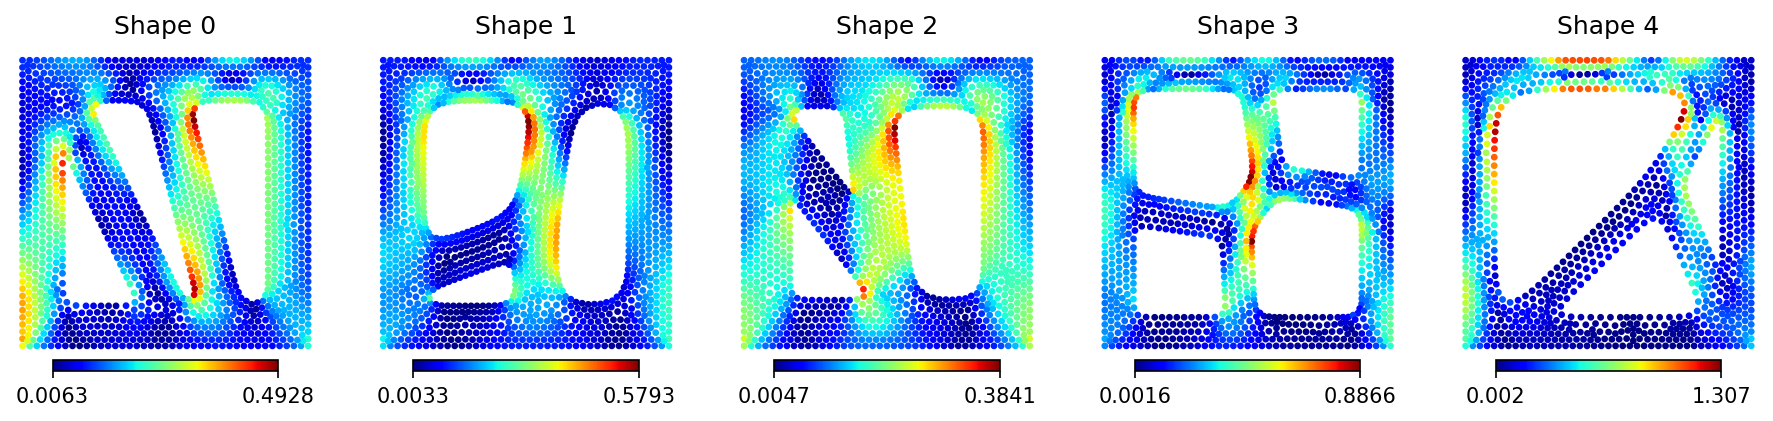

In [134]:
data_path = "../HW9/data/stress_nodal_features.npy"  # updated for correct file path
dataset_train, dataset_test, X_train, X_test, y_train, y_test = load_dataset(data_path)
N_train = len(dataset_train["stress"])
N_test = len(dataset_test["stress"])

plt.figure(figsize=[15,3.2], dpi=150)
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_shape(dataset_train,i)
    plt.title(f"Shape {i}")
plt.show()

## Neural network to predict stress

Create a PyTorch neural network class `StressPredictor` below. This should be an MLP with 60 inputs (the given features) and 1 output (stress). The hidden layer sizes and activations are up to you.

In [135]:
import torch.nn.functional as F

class StressPredictor(nn.Module):
    # YOUR CODE GOES HERE
    input_size = 60
    hidden_size = 64
    output_size = 1

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lin1 = nn.Linear(input_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x

## Training function

Below, you should define a function `train(model, dataset, lr, epochs)` that will train `model` on the data in `dataset` with the Adam optimizer for `epochs` epochs with a learning rate of `lr`.

Because there are so many total nodes, you should treat each shape as a batch of nodes -- each epoch of training will require you to loop through each shape in the dataset in a random order, performing a step of gradient descent for each shape encountered. Your function should automatically generate a plot of the loss curve on training data.

- You can use the provided `get_shape` to access feature and output tensors for each shape. 
- Use MSE as a your loss function.
- Look into `np.random.permutation()` for generating a random index order 

In [136]:
def train(model, dataset, lr, epochs):
    # YOUR CODE GOES HERE
    # use np.random.permutation(N_train) to shuffle the training data
    lossfun = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    train_hist = []
    val_hist = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i in np.random.permutation(len(dataset["features"])):
            x, y = get_shape(dataset, i)
            opt.zero_grad()
            y_pred = model(x)
            loss = lossfun(y_pred, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
            
        train_hist.append(train_loss / len(dataset["features"]))

        model.eval()
        val_loss = 0
        for i in range(N_test):
            x, y = get_shape(dataset, i)
            y_pred = model(x)
            loss = lossfun(y_pred, y)
            val_loss += loss.item()
        val_hist.append(val_loss / len(dataset["features"]))

    # plot the loss curves
    plt.figure(dpi=250)
    plt.plot(train_hist, label="Train")
    # plt.plot(val_hist, label="Validation")
    plt.title("Loss Curves on the Training Data")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    # plt.legend()
    plt.show()

## Training your Neural Network

Now, create your neural network model and run your train function on the training dataset `dataset_train`.  
Determining the right number of epochs and learning rate are up to you. The training loss curve should be shown.

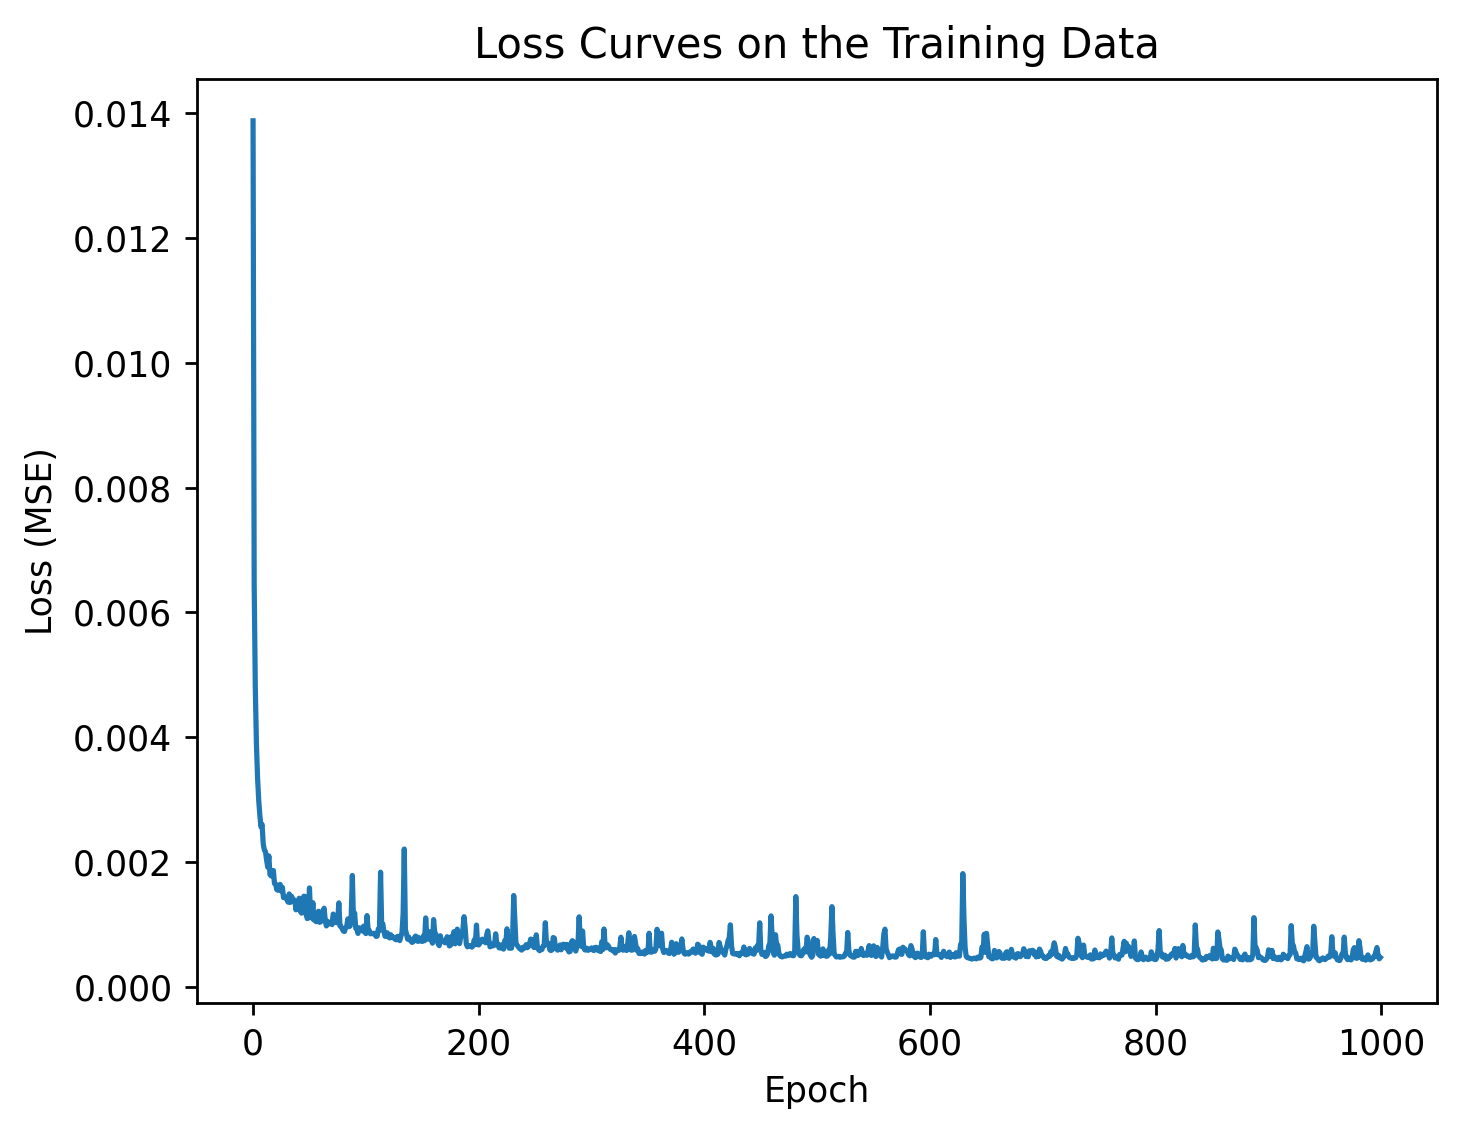

In [137]:
# YOUR CODE GOES HERE
lr = 1e-3
epochs = 1000
model = StressPredictor(60, 64, 1)
train(model, dataset_train, lr, epochs)

## $R^2$ Score

Compute the $R^2$ Score on the training dataset. You will have to convert between tensors and arrays versions to use sklearn functions, or you can write your own function.

In [138]:
# YOUR CODE GOES HERE
# covert to tensor
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()

# predict the stress
y_train_pred = model(X_train_tensor).detach().numpy()
y_test_pred = model(X_test_tensor).detach().numpy()

# calculate the R^2 score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 score on the training dataset: {r2_train:.4f}")
print(f"R^2 score on the test dataset: {r2_test:.4f}")

R^2 score on the training dataset: 0.9806
R^2 score on the test dataset: 0.9181


## $R^2$ Plots

Now, generate predicted-vs-actual plots that display both data and a theoretical best fit line. Make 2 such plots - one for training data and one for testing.

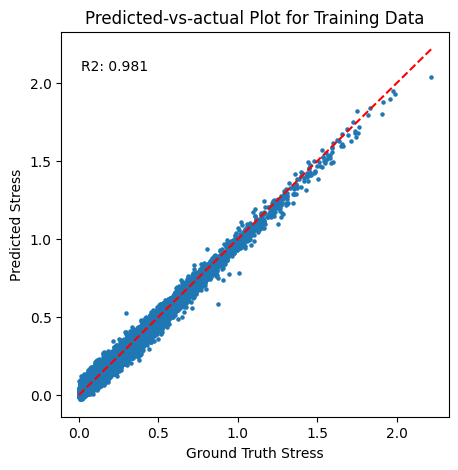

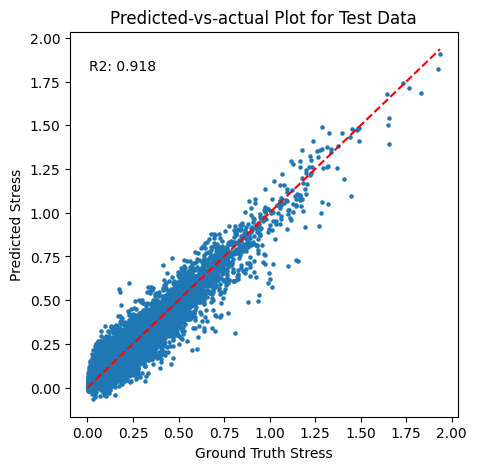

In [139]:
# YOUR CODE GOES HERE
def plot_r2(y_true, y_pred, title):
    plt.figure(figsize=[5,5])
    plt.scatter(y_true, y_pred, s=5)
    plt.text(0.05, 0.9, f"R2: {r2_score(y_true, y_pred):.3f}", transform=plt.gca().transAxes)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "r--")
    
    plt.xlabel("Ground Truth Stress")
    plt.ylabel("Predicted Stress")
    plt.title(title)
    plt.show()

plot_r2(y_train, y_train_pred,"Predicted-vs-actual Plot for Training Data")
plot_r2(y_test, y_test_pred, "Predicted-vs-actual Plot for Test Data")

## Individual Shape $R^2$

Because we have a unique problem where groups of nodes in a dataset form a single shape, we can compute an $R^2$ score for an individual shape.
For each shape in the training set, compute an $R^2$ score. Then create a histogram of the values with the function `plot_r2_hist(r2s)`. Repeat for the testing set.

Report the median $R^2$ score across all training shapes, and the median across all testing shapes.

If your test median is below 0.85, try and tune your network size/training hyperparameters until it reaches this threshold.

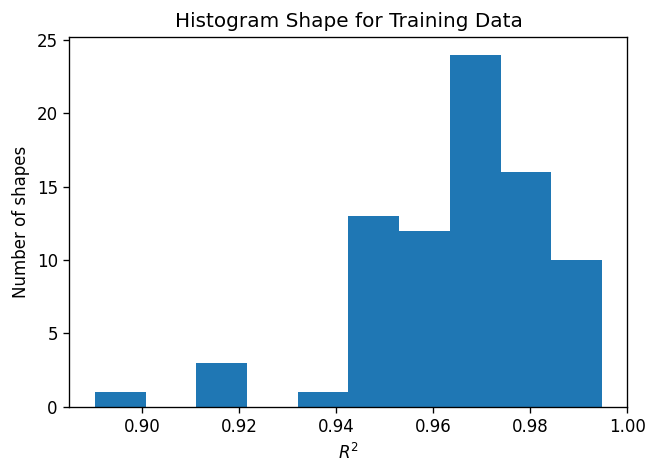

Median R^2 on the training dataset: 0.9683


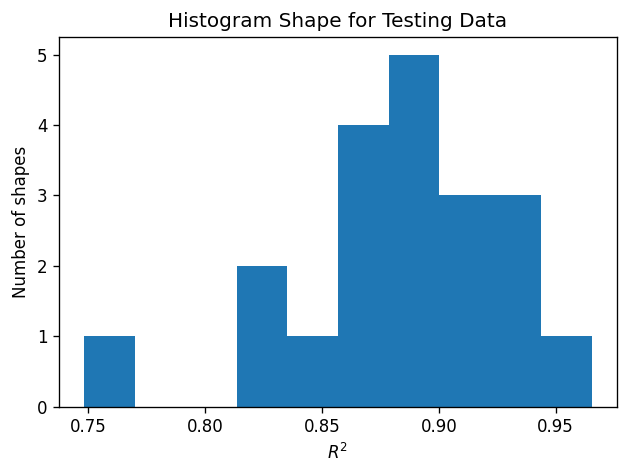

Median R^2 on the testing dataset: 0.8890


In [140]:
# YOUR CODE GOES HERE
def r2_shape(dataset, model):
    r2_scores = []
    for i in range(len(dataset["features"])):
        x, y = get_shape(dataset, i)
        y_pred = model(x).detach().numpy()
        r2_scores.append(r2_score(y, y_pred))
    return r2_scores

r2_scores_train = r2_shape(dataset_train, model) 
r2_scores_test = r2_shape(dataset_test, model)

# plot and median for training data
plot_r2_distribution(r2_scores_train, "Histogram Shape for Training Data")
r2_train_median = np.median(r2_scores_train)
print(f"Median R^2 on the training dataset: {r2_train_median:.4f}")

# plot and median for test data
plot_r2_distribution(r2_scores_test, "Histogram Shape for Testing Data")
r2_test_median = np.median(r2_scores_test)
print(f"Median R^2 on the testing dataset: {r2_test_median:.4f}")